In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import io
from contextlib import redirect_stdout, redirect_stderr
import powerlaw

from collections import defaultdict
import matplotlib as mpl
import numpy as np

params = {'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':12,
         'ytick.labelsize':15,
         'axes.titlepad': 1,
         'axes.labelpad': 1,
         'axes.grid': True,
          'legend.fontsize': 15
    }
mpl.rcParams.update(params)

import numpy as np
import matplotlib.pyplot as plt
import random
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
import matplotlib.cbook


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import json

# c = 'steelblue'
# base_c = 'lightskyblue'
import seaborn as sns
c = 'coral'
c1 = 'yellowgreen'
base_c = 'aqua'

plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='STIXGeneral')

yaxisfont=45
bigfont = 27 + 5
medfont = 15 
smallfont = 17

plt.rcParams['xtick.labelsize']=medfont
plt.rcParams['ytick.labelsize']=medfont
plt.rcParams['axes.titlesize']=medfont

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 16})

sns.set_palette("muted")
cmap = sns.color_palette("tab10")
ticks_fontsize = 18
label_fontsize = 20
cbar_fontsize = 18


EVALS_THRESH = 0.00001
thresh = EVALS_THRESH
XMIN_MID = 'xmin_mid'
XMIN_PEAK = 'xmin_peak'
POWER_LAW = 'power_law'
TRUNCATED_POWER_LAW='truncated_power_law'

def pl_fit(data=None, xmin=None, xmax=None, verbose=False, distribution='PL'):
    f = io.StringIO()
    with redirect_stdout(f), redirect_stderr(f), warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        return powerlaw.Fit(data, xmin=xmin, xmax=xmax, 
                verbose=verbose, distribution=distribution, 
                xmin_distribution=distribution)

def plot_loghist(x, bins, xmin, legend, color):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, density=True, alpha=0.2, label=legend, color=color)

    if xmin:
        plt.axvline(xmin, color=color, label=r'$\lambda_{min}$')

    plt.xscale('log')

In [18]:
import re
ckpt_dir = '/scratch/tpang/zhliu/checkpoints/nlp'
lm_dir = os.path.join(ckpt_dir, 'lm/tensorized/baseline/ptb-adam/bs120/tensor_transformer_3layer/head_1/max_step40000_max_epoch200_log_interval200/xmin_mid_xmin_pos2/warmup_0')
lr_list = [0.000125]
seed_list = [13, 37, 43, 51, 71]
for lr in lr_list:
    for seed in seed_list:
        esd_dict = defaultdict(list)
        name_dict = defaultdict(list)
        seed_dir = os.path.join(lm_dir, f'seed_{seed}_lr_{lr}')
        metrics = np.load(os.path.join(seed_dir, 'esd_best.npy'), allow_pickle=True).item()
        layer_names = metrics['longname']
        for idx, (name, eigs) in enumerate(zip(metrics['longname'][: -1], metrics['eigs'][: -1])):
            print(name)
            match = re.search(r'layers\.(\d+)\.', name)
            number = int(match.group(1))
            if number not in esd_dict.keys():
                esd_dict[number] = []
            esd_dict[number] += eigs.tolist()

        break


for name in layer_names:
    match = re.search(r'layers\.(\d+)\.', name)
    if match:
        number = int(match.group(1))
        # add new entry to dict if not exist
        if number not in name_dict.keys():
            name_dict[number] = []
        name_dict[number].append(name)

print(name_dict)


layers.0.dec_attn.qkv_net
layers.0.dec_attn.o_net
layers.0.dec_attn.r_net
layers.0.pos_ff.CoreNet.0
layers.0.pos_ff.CoreNet.3
layers.1.dec_attn.qkv_net
layers.1.dec_attn.o_net
layers.1.dec_attn.r_net
layers.1.pos_ff.CoreNet.0
layers.1.pos_ff.CoreNet.3
layers.2.dec_attn.qkv_net
layers.2.dec_attn.o_net
layers.2.dec_attn.r_net
layers.2.pos_ff.CoreNet.0
layers.2.pos_ff.CoreNet.3
defaultdict(<class 'list'>, {0: ['layers.0.dec_attn.qkv_net', 'layers.0.dec_attn.o_net', 'layers.0.dec_attn.r_net', 'layers.0.pos_ff.CoreNet.0', 'layers.0.pos_ff.CoreNet.3'], 1: ['layers.1.dec_attn.qkv_net', 'layers.1.dec_attn.o_net', 'layers.1.dec_attn.r_net', 'layers.1.pos_ff.CoreNet.0', 'layers.1.pos_ff.CoreNet.3'], 2: ['layers.2.dec_attn.qkv_net', 'layers.2.dec_attn.o_net', 'layers.2.dec_attn.r_net', 'layers.2.pos_ff.CoreNet.0', 'layers.2.pos_ff.CoreNet.3']})


In [28]:
distribution = 'power_law' #truncated_ truncated_
fit_type=distribution
fix_fingers="xmin_mid" #"xmin_peak"
xmin_pos = 2
c_idx = 0
for idx, (key, evals) in enumerate(esd_dict.items()):
    evals = np.array(evals)
    plt.figure(figsize=(10, 8))
    title = f'layer_{key} \n'
    xmax = np.max(evals)

    if fix_fingers==XMIN_PEAK:
        print("fix the fingers by setting xmin to the peak of the ESD")
        # nz_evals = evals[evals > thresh]
        nz_evals = evals
        num_bins = 100  # np.min([100, len(nz_evals)])
        h = np.histogram(np.log10(nz_evals), bins=num_bins)
        ih = np.argmax(h[0])
        xmin2 = 10 ** h[1][ih]
        xmin_range = (0.95 * xmin2, 1.05 * xmin2)
        fit = pl_fit(data=nz_evals, xmin=xmin_range,
            xmax=xmax, verbose=False, 
            distribution=distribution)

    elif fix_fingers==XMIN_MID:
        # print("fix the fingers by setting xmin to the mid of the ESD")
        # nz_evals = evals[evals > thresh]
        nz_evals = evals
        i = int(len(nz_evals) / xmin_pos)
        xmin = nz_evals[i]
        fit = pl_fit(data=nz_evals, xmin=xmin,
            xmax=xmax, verbose=False, 
            distribution=distribution)

    else: 
        print("powerlaw.Fit no xmin , distribution={} ".format(distribution))
        # nz_evals = evals[evals > thresh]
        nz_evals = evals
        fit = pl_fit(data=nz_evals, xmax=xmax, verbose=False, distribution=distribution) 
    
    xmin = fit.xmin
    alpha = fit.alpha
    D = fit.D
    if fit_type==TRUNCATED_POWER_LAW:
        alpha = fit.truncated_power_law.alpha
        Lambda = fit.truncated_power_law.Lambda
        D = fit.truncated_power_law.D

    fig2 = fit.plot_pdf(color='b', linewidth=0) # invisbile
    fig2 = fit.plot_pdf(color=cmap[c_idx], linewidth=2) #color='orange',
    if fit_type==POWER_LAW:
        fit.power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2) #color='r',
        title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
            r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
            r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + \
            f'num of eigs: {len(nz_evals)}' "\n" 
    else:
        fit.truncated_power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2)
        title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
            r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
            r'$Lambda=$'+"{0:.3f};".format(Lambda) + \
            r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + "\n"

    plot_loghist(evals[evals>(xmin/100)], 
                bins=100, xmin=xmin, legend=f'Epoch=best', color=cmap[c_idx])
    
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    # make new dir if not exist
    if not os.path.exists(f"/scratch/tpang/zhliu/repos/ww_nlp_lm/BTD-Transformer/figures/esd/fix_{fix_fingers}/tensorized/best_epoch"):
        os.makedirs(f"/scratch/tpang/zhliu/repos/ww_nlp_lm/BTD-Transformer/figures/esd/fix_{fix_fingers}/tensorized/best_epoch")

    plt.savefig(f"/scratch/tpang/zhliu/repos/ww_nlp_lm/BTD-Transformer/figures/esd/fix_{fix_fingers}/tensorized/best_epoch/layer_{key}.png")
    plt.close()

In [3]:
import re
ckpt_dict = {
    'baseline': 'baseline',
    'acc_v_0.2_1.6': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.2_slope1.6',
    'acc_v_0.4_1.2': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.4_slope1.2',
    'acc_v_0.5_1.0': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.5_slope1.0',
    'acc_v_0.6_0.8': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.6_slope0.8',
    'acc_v_0.8_0.4': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.8_slope0.4',
}
task = 'mt_iwslt14_de_en'
ckpt_dir = '/scratch/tpang/zhliu/checkpoints/nlp/mt/iwslt14_de_en'
lm_dir = os.path.join(ckpt_dir, '/baseline')
lr_list = [0.000125]
seed_list = [13, 37, 43, 51, 71]
esd_dict = defaultdict(list)
name_dict = defaultdict(list)
seed_dir = os.path.join(lm_dir, f'transformer_iwslt_de_en_v2_iwslt14_de_en_seed43')
metrics = np.load(os.path.join(seed_dir, 'metrics_update60500.npy'), allow_pickle=True).item()
layer_names = metrics['longname']

for config in ckpt_dict.keys():
    seed_dir = os.path.join(ckpt_dir, ckpt_dict[config])
    metrics = np.load(os.path.join(seed_dir, 'metrics_update60500.npy'), allow_pickle=True).item()
    for idx, (name, eigs) in enumerate(zip(metrics['longname'], metrics['eigs'])):
        print(name)
        match = re.search(r'(\w+)\.layers\.(\d+)\.', name)
        layer_type = match.group(1)
        number = int(match.group(2))
        key = f'{layer_type}_{number}'
        if key not in name_dict.keys():
            name_dict[key] = []
        esd_dict[key] += eigs.tolist()



    for name in layer_names:
        match = re.search(r'(\w+)\.layers\.(\d+)\.', name)
        if match:
            layer_type = match.group(1)
            number = int(match.group(2))
            key = f'{layer_type}_{number}'
            # add new entry to dict if not exist
            if key not in name_dict.keys():
                name_dict[key] = []
            name_dict[key].append(name)

    print(name_dict)

    distribution = 'power_law' #truncated_ truncated_
    fit_type=distribution
    fix_fingers="xmin_mid" #"xmin_peak"
    xmin_pos = 2
    c_idx = 0
    for idx, (key, evals) in enumerate(esd_dict.items()):
        evals = np.array(evals)
        # sort them in increasing order
        evals = np.sort(evals)
        plt.figure(figsize=(10, 8))
        title = f'layer_{key}, fit: {fix_fingers} \n'
        xmax = np.max(evals)

        if fix_fingers==XMIN_PEAK:
            print("fix the fingers by setting xmin to the peak of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            num_bins = 100  # np.min([100, len(nz_evals)])
            h = np.histogram(np.log10(nz_evals), bins=num_bins)
            ih = np.argmax(h[0])
            xmin2 = 10 ** h[1][ih]
            xmin_range = (0.95 * xmin2, 1.05 * xmin2)
            fit = pl_fit(data=nz_evals, xmin=xmin_range,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        elif fix_fingers==XMIN_MID:
            # print("fix the fingers by setting xmin to the mid of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            i = int(len(nz_evals) / xmin_pos)
            xmin = nz_evals[i]
            fit = pl_fit(data=nz_evals, xmin=xmin,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        else: 
            print("powerlaw.Fit no xmin , distribution={} ".format(distribution))
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            fit = pl_fit(data=nz_evals, xmax=xmax, verbose=False, distribution=distribution) 
        
        xmin = fit.xmin
        alpha = fit.alpha
        D = fit.D
        if fit_type==TRUNCATED_POWER_LAW:
            alpha = fit.truncated_power_law.alpha
            Lambda = fit.truncated_power_law.Lambda
            D = fit.truncated_power_law.D

        fig2 = fit.plot_pdf(color='b', linewidth=0) # invisbile
        fig2 = fit.plot_pdf(color=cmap[c_idx], linewidth=2) #color='orange',
        if fit_type==POWER_LAW:
            fit.power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2) #color='r',
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + \
                f'num of eigs: {len(nz_evals)}' "\n" 
        else:
            fit.truncated_power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2)
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r'$Lambda=$'+"{0:.3f};".format(Lambda) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + "\n"

        plot_loghist(evals[evals>(xmin/100)], 
                    bins=100, xmin=xmin, legend=f'Epoch=best', color=cmap[c_idx])
        
        plt.title(title)
        plt.legend()
        plt.tight_layout()

        # make new dir if not exist
        if not os.path.exists(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch"):
            os.makedirs(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch")

        plt.savefig(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch/layer_{key}.png")
        plt.close()


encoder.layers.0.self_attn.k_proj
encoder.layers.0.self_attn.v_proj
encoder.layers.0.self_attn.q_proj
encoder.layers.0.self_attn.out_proj
encoder.layers.0.fc1
encoder.layers.0.fc2
encoder.layers.1.self_attn.k_proj
encoder.layers.1.self_attn.v_proj
encoder.layers.1.self_attn.q_proj
encoder.layers.1.self_attn.out_proj
encoder.layers.1.fc1
encoder.layers.1.fc2
encoder.layers.2.self_attn.k_proj
encoder.layers.2.self_attn.v_proj
encoder.layers.2.self_attn.q_proj
encoder.layers.2.self_attn.out_proj
encoder.layers.2.fc1
encoder.layers.2.fc2
encoder.layers.3.self_attn.k_proj
encoder.layers.3.self_attn.v_proj
encoder.layers.3.self_attn.q_proj
encoder.layers.3.self_attn.out_proj
encoder.layers.3.fc1
encoder.layers.3.fc2
encoder.layers.4.self_attn.k_proj
encoder.layers.4.self_attn.v_proj
encoder.layers.4.self_attn.q_proj
encoder.layers.4.self_attn.out_proj
encoder.layers.4.fc1
encoder.layers.4.fc2
encoder.layers.5.self_attn.k_proj
encoder.layers.5.self_attn.v_proj
encoder.layers.5.self_attn.q_pro

In [27]:
for key, eigs in esd_dict.items():
    print(key)
    print([x for x in eigs if x < 1e-4])

encoder_0
[1.7512014892417938e-05, 2.9817123504471965e-05, 8.109552436508238e-05, 1.0177132914179765e-08, 8.559182606404647e-05, 4.008591076853918e-06, 2.7123796826344915e-06]
encoder_1
[5.421642981673358e-06, 5.2504317864077166e-05, 2.169662548112683e-05, 1.8748454749584198e-05, 3.0001803679624572e-05, 9.70510664046742e-05, 1.110569246520754e-05, 5.655779023072682e-05]
encoder_2
[2.4976390704978257e-05, 4.5965909521328285e-05, 2.2548361812368967e-05, 4.658164834836498e-05, 3.707918267537025e-06, 3.8388789107557386e-05, 2.6468917440070072e-06, 5.1333525334484875e-05, 9.137961023952812e-05]
encoder_3
[1.534823326210244e-07, 2.7332313038641587e-05, 6.208039121702313e-05, 1.3313950830706744e-06, 3.2089603337226436e-05, 6.347257112793159e-06, 4.21052573074121e-05, 1.2671385775320232e-05, 6.812452193116769e-05]
encoder_4
[7.419231224048417e-06, 5.156347106094472e-05, 7.83768409746699e-05, 2.3960812995937886e-06, 2.312449760211166e-05, 7.94844891061075e-05, 8.702237209945451e-06, 2.697582203

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import io
from contextlib import redirect_stdout, redirect_stderr
import powerlaw

from collections import defaultdict
import matplotlib as mpl
import numpy as np

params = {'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':12,
         'ytick.labelsize':15,
         'axes.titlepad': 1,
         'axes.labelpad': 1,
         'axes.grid': True,
          'legend.fontsize': 15
    }
mpl.rcParams.update(params)

import numpy as np
import matplotlib.pyplot as plt
import random
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
import matplotlib.cbook


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import json

# c = 'steelblue'
# base_c = 'lightskyblue'
import seaborn as sns
c = 'coral'
c1 = 'yellowgreen'
base_c = 'aqua'

plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='STIXGeneral')

yaxisfont=45
bigfont = 27 + 5
medfont = 15 
smallfont = 17

plt.rcParams['xtick.labelsize']=medfont
plt.rcParams['ytick.labelsize']=medfont
plt.rcParams['axes.titlesize']=medfont

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 16})

sns.set_palette("muted")
cmap = sns.color_palette("tab10")
ticks_fontsize = 18
label_fontsize = 20
cbar_fontsize = 18


EVALS_THRESH = 0.00001
thresh = EVALS_THRESH
XMIN_PEAK = 'xmin_peak'
XMIN_MID = 'xmin_mid'
POWER_LAW = 'power_law'
TRUNCATED_POWER_LAW='truncated_power_law'
xmin_pos = 2

def pl_fit(data=None, xmin=None, xmax=None, verbose=False, distribution='PL'):
    f = io.StringIO()
    with redirect_stdout(f), redirect_stderr(f), warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        return powerlaw.Fit(data, xmin=xmin, xmax=xmax, 
                verbose=verbose, distribution=distribution, 
                xmin_distribution=distribution)

def plot_loghist(x, bins, xmin, legend, color):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, density=True, alpha=0.2, label=legend, color=color)

    if xmin:
        plt.axvline(xmin, color=color, label=r'$\lambda_{min}$')

    plt.xscale('log')

ckpt_dict = {
    'baseline': 'baseline/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43',
    'acc_v_0.2_1.6': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.2_slope1.6',
    'acc_v_0.4_1.2': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.4_slope1.2',
    'acc_v_0.5_1.0': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.5_slope1.0',
    'acc_v_0.6_0.8': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.6_slope0.8',
    'acc_v_0.8_0.4': 'adam_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.8_slope0.4',
}
task = 'mt_iwslt14_de_en'
ckpt_dir = '/scratch/tpang/zhliu/checkpoints/nlp/mt/iwslt14_de_en'

distribution = 'power_law' #truncated_ truncated_
fit_type=distribution
fix_fingers="xmin_mid" #"xmin_peak"
c_idx = 0

for config in ckpt_dict.keys():
    seed_dir = os.path.join(ckpt_dir, ckpt_dict[config])
    esd = np.load(os.path.join(seed_dir, 'metrics_update60500.npy'), allow_pickle=True).item()
    layer_names = esd['longname']
    for idx, (evals, layer_name) in enumerate(zip(esd['eigs'], esd['longname'])):
        plt.figure(figsize=(10, 8))
        title = f'{layer_name}, fit: {fix_fingers} \n'
        xmax = np.max(evals)

        if fix_fingers==XMIN_PEAK:
            print("fix the fingers by setting xmin to the peak of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            num_bins = 100  # np.min([100, len(nz_evals)])
            h = np.histogram(np.log10(nz_evals), bins=num_bins)
            ih = np.argmax(h[0])
            xmin2 = 10 ** h[1][ih]
            xmin_range = (0.95 * xmin2, 1.05 * xmin2)
            fit = pl_fit(data=nz_evals, xmin=xmin_range,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        elif fix_fingers==XMIN_MID:
            # print("fix the fingers by setting xmin to the mid of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            i = int(len(nz_evals) / xmin_pos)
            xmin = nz_evals[i]
            fit = pl_fit(data=nz_evals, xmin=xmin,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        else: 
            print("powerlaw.Fit no xmin , distribution={} ".format(distribution))
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            fit = pl_fit(data=nz_evals, xmax=xmax, verbose=False, distribution=distribution) 
        
        xmin = fit.xmin
        alpha = fit.alpha
        D = fit.D
        if fit_type==TRUNCATED_POWER_LAW:
            alpha = fit.truncated_power_law.alpha
            Lambda = fit.truncated_power_law.Lambda
            D = fit.truncated_power_law.D

        fig2 = fit.plot_pdf(color='b', linewidth=0) # invisbile
        fig2 = fit.plot_pdf(color=cmap[c_idx], linewidth=2) #color='orange',
        if fit_type==POWER_LAW:
            fit.power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2) #color='r',
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + \
                f'num of eigs: {len(nz_evals)}' "\n" 
        else:
            fit.truncated_power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2)
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r'$Lambda=$'+"{0:.3f};".format(Lambda) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + "\n"

        plot_loghist(evals[evals>(xmin/100)], 
                    bins=100, xmin=xmin, legend=f'Epoch=best', color=cmap[c_idx])
        
        plt.title(title)
        plt.legend()
        plt.tight_layout()

        # make new dir if not exist
        if not os.path.exists(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch"):
            os.makedirs(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch")

        plt.savefig(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch/{layer_name}.png")
        plt.close()

In [18]:
for model in model_ckpt_dir.keys():
    esd = np.load(model_ckpt_dir[model], allow_pickle=True).item()
    layer_names = esd['longname']
    for idx, (evals, layer_name) in enumerate(zip(esd['eigs'], esd['longname'])):
        if 'decoder.layers.4' in layer_name:
            print(layer_name)
            print(len(evals))
            # print(evals)
            print(len(evals[evals < 1e-4]))

decoder.layers.4.self_attn.k_proj
512
1
decoder.layers.4.self_attn.v_proj
512
2
decoder.layers.4.self_attn.q_proj
512
1
decoder.layers.4.self_attn.out_proj
512
1
decoder.layers.4.encoder_attn.k_proj
512
2
decoder.layers.4.encoder_attn.v_proj
512
1
decoder.layers.4.encoder_attn.q_proj
512
1
decoder.layers.4.encoder_attn.out_proj
512
1
decoder.layers.4.fc1
512
0
decoder.layers.4.fc2
512
0


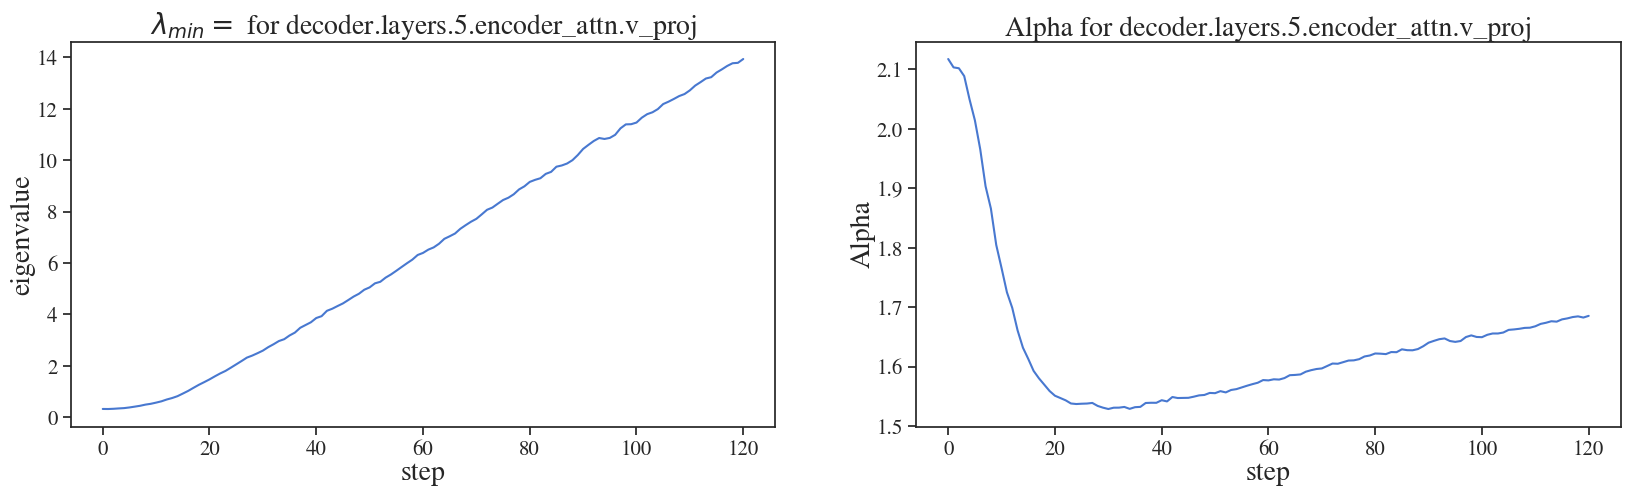

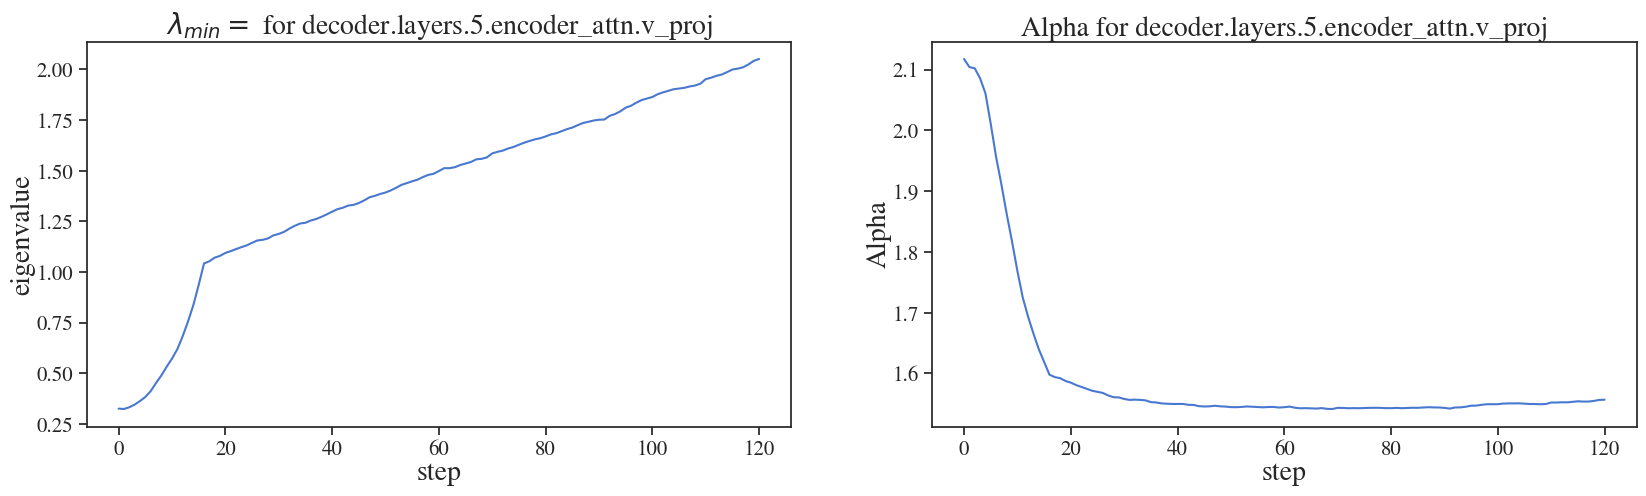

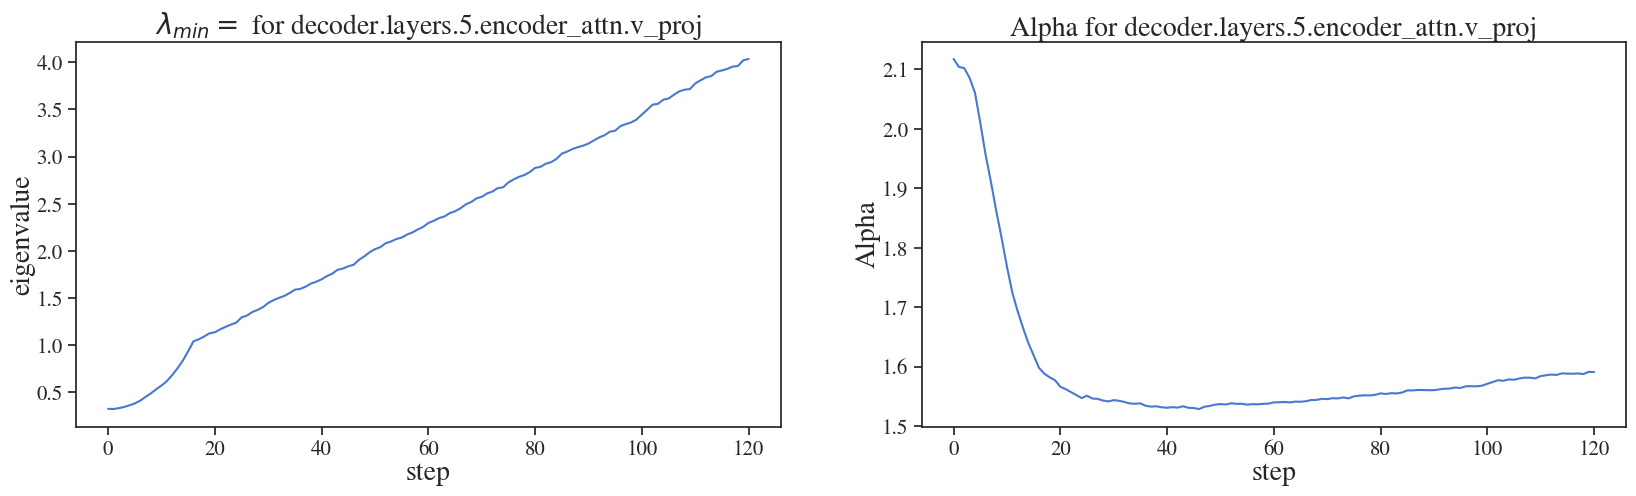

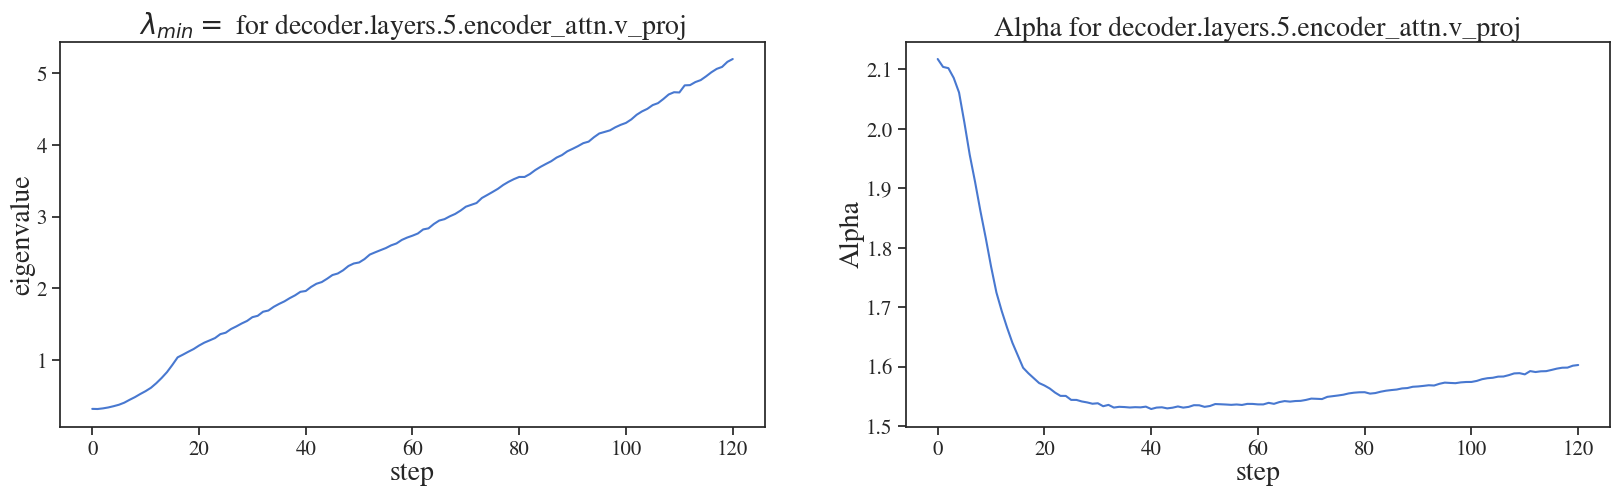

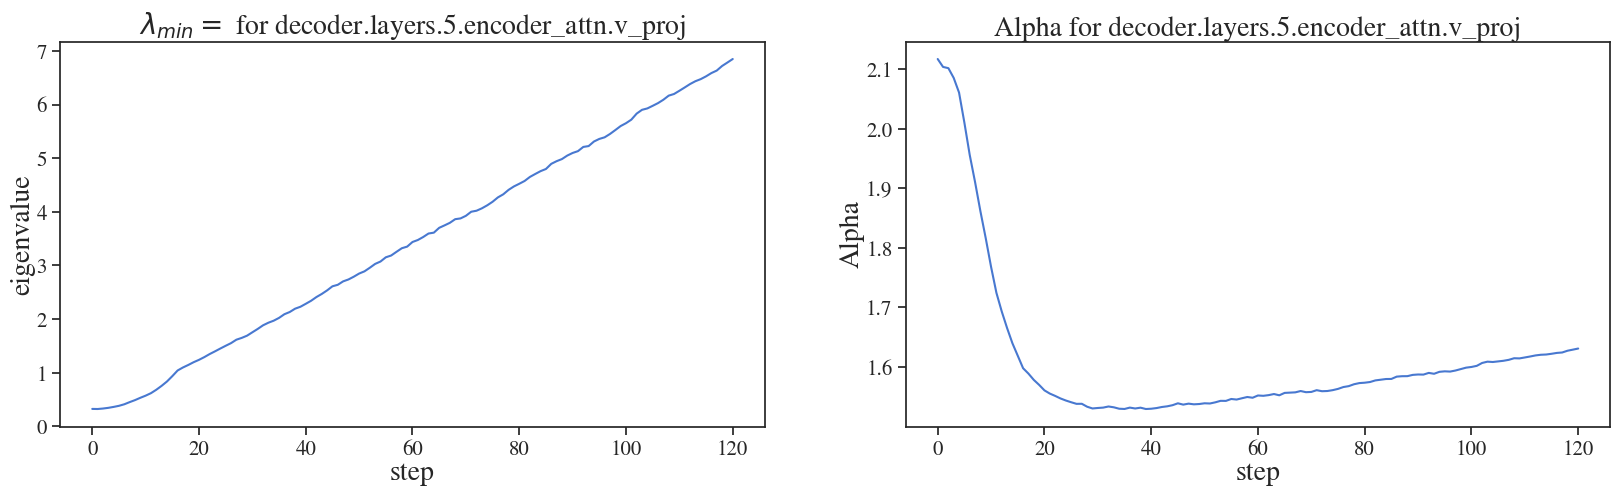

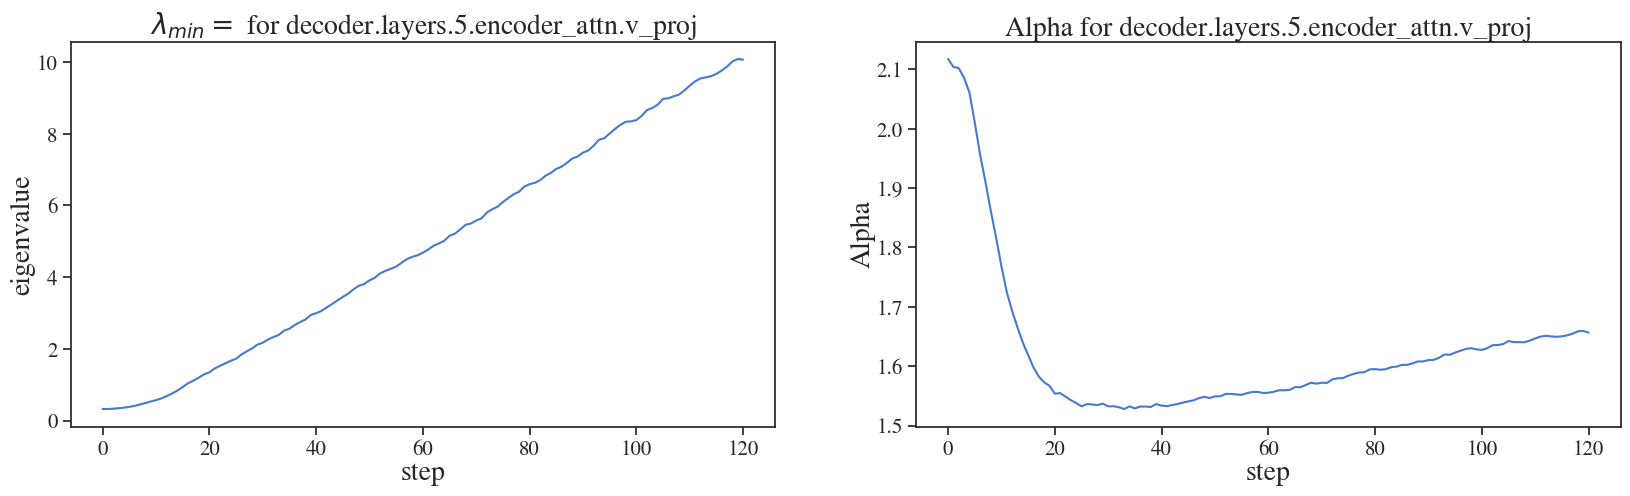

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import io
from contextlib import redirect_stdout, redirect_stderr
import powerlaw

from collections import defaultdict
import matplotlib as mpl
import numpy as np

params = {'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':12,
         'ytick.labelsize':15,
         'axes.titlepad': 1,
         'axes.labelpad': 1,
         'axes.grid': True,
          'legend.fontsize': 15
    }
mpl.rcParams.update(params)

import numpy as np
import matplotlib.pyplot as plt
import random
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
import matplotlib.cbook


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import json

# c = 'steelblue'
# base_c = 'lightskyblue'
import seaborn as sns
c = 'coral'
c1 = 'yellowgreen'
base_c = 'aqua'

plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='STIXGeneral')

yaxisfont=45
bigfont = 27 + 5
medfont = 15 
smallfont = 17

plt.rcParams['xtick.labelsize']=medfont
plt.rcParams['ytick.labelsize']=medfont
plt.rcParams['axes.titlesize']=medfont

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 16})

sns.set_palette("muted")
cmap = sns.color_palette("tab10")
ticks_fontsize = 18
label_fontsize = 20
cbar_fontsize = 18


EVALS_THRESH = 0.00001
thresh = EVALS_THRESH
XMIN_PEAK = 'xmin_peak'
XMIN_MID = 'xmin_mid'
POWER_LAW = 'power_law'
TRUNCATED_POWER_LAW='truncated_power_law'
xmin_pos = 2

def pl_fit(data=None, xmin=None, xmax=None, verbose=False, distribution='PL'):
    f = io.StringIO()
    with redirect_stdout(f), redirect_stderr(f), warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        return powerlaw.Fit(data, xmin=xmin, xmax=xmax, 
                verbose=verbose, distribution=distribution, 
                xmin_distribution=distribution)

def plot_loghist(x, bins, xmin, legend, color):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, density=True, alpha=0.2, label=legend, color=color)

    if xmin:
        plt.axvline(xmin, color=color, label=r'$\lambda_{min}$')

    plt.xscale('log')

ckpt_dict = {
    'baseline': 'baseline/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43',
    'cross_acc_v_0.2_1.6': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.2_slope1.6',
    'cross_acc_v_0.4_1.2': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.4_slope1.2',
    'cross_acc_v_0.5_1.0': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.5_slope1.0',
    'cross_acc_v_0.6_0.8': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.6_slope0.8',
    'cross_acc_v_0.8_0.4': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.8_slope0.4',
}
task = 'mt_iwslt14_de_en'
ckpt_dir = '/scratch/tpang/zhliu/checkpoints/nlp/mt/iwslt14_de_en'

distribution = 'power_law' #truncated_ truncated_
fit_type=distribution
fix_fingers="xmin_mid" #"xmin_peak"
c_idx = 0
layer_name = 'decoder.layers.5.encoder_attn.v_proj'

for config in ckpt_dict.keys():
    seed_dir = os.path.join(ckpt_dir, ckpt_dict[config])
    xmin_list = []
    alpha_list = []
    xmax_list = []
    for step in range(0, 60500, 500):
        esd = np.load(os.path.join(seed_dir, f'metrics_update{step}.npy'), allow_pickle=True).item()
        layer_names = esd['longname']
        layer_idx = esd['longname'].index(layer_name)
        evals = esd['eigs'][layer_idx]
        plt.figure(figsize=(10, 8))
        title = f'{layer_name}, fit: {fix_fingers} \n'
        xmax = np.max(evals)
        xmax_list.append(xmax)

        if fix_fingers==XMIN_PEAK:
            print("fix the fingers by setting xmin to the peak of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            num_bins = 100  # np.min([100, len(nz_evals)])
            h = np.histogram(np.log10(nz_evals), bins=num_bins)
            ih = np.argmax(h[0])
            xmin2 = 10 ** h[1][ih]
            xmin_range = (0.95 * xmin2, 1.05 * xmin2)
            fit = pl_fit(data=nz_evals, xmin=xmin_range,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        elif fix_fingers==XMIN_MID:
            # print("fix the fingers by setting xmin to the mid of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            i = int(len(nz_evals) / xmin_pos)
            xmin = nz_evals[i]
            fit = pl_fit(data=nz_evals, xmin=xmin,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        else: 
            print("powerlaw.Fit no xmin , distribution={} ".format(distribution))
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            fit = pl_fit(data=nz_evals, xmax=xmax, verbose=False, distribution=distribution) 
        
        xmin = fit.xmin
        alpha = fit.alpha
        D = fit.D
        if fit_type==TRUNCATED_POWER_LAW:
            alpha = fit.truncated_power_law.alpha
            Lambda = fit.truncated_power_law.Lambda
            D = fit.truncated_power_law.D

        xmin_list.append(xmin)
        alpha_list.append(alpha)
        fig2 = fit.plot_pdf(color='b', linewidth=0) # invisbile
        fig2 = fit.plot_pdf(color=cmap[c_idx], linewidth=2) #color='orange',
        if fit_type==POWER_LAW:
            fit.power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2) #color='r',
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + \
                f'num of eigs: {len(nz_evals)}' "\n" 
        else:
            fit.truncated_power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2)
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r'$Lambda=$'+"{0:.3f};".format(Lambda) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + "\n"

        plot_loghist(evals[evals>(xmin/100)], 
                    bins=100, xmin=xmin, legend=f'Epoch=best', color=cmap[c_idx])
        
        plt.title(title)
        plt.legend()
        plt.tight_layout()

        # make new dir if not exist
        if not os.path.exists(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch/{layer_name}"):
            os.makedirs(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch/{layer_name}")

        plt.savefig(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch/{layer_name}/esd_step{step}.png")
        plt.close()

    # plot xmin and alpha:
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(xmin_list)
    axs[1].plot(alpha_list)
    axs[0].set_xlabel('step', fontsize=20)
    axs[0].set_ylabel('eigenvalue', fontsize=20)
    axs[0].set_title(r"$\lambda_{min}=$" + f" for {layer_name}", fontsize=20)
    # axs[0].legend()

    axs[1].set_xlabel('step', fontsize=20)
    axs[1].set_ylabel('Alpha', fontsize=20)
    axs[1].set_title(f'Alpha for {layer_name}', fontsize=20)
    # axs[1].legend()
    plt.show()

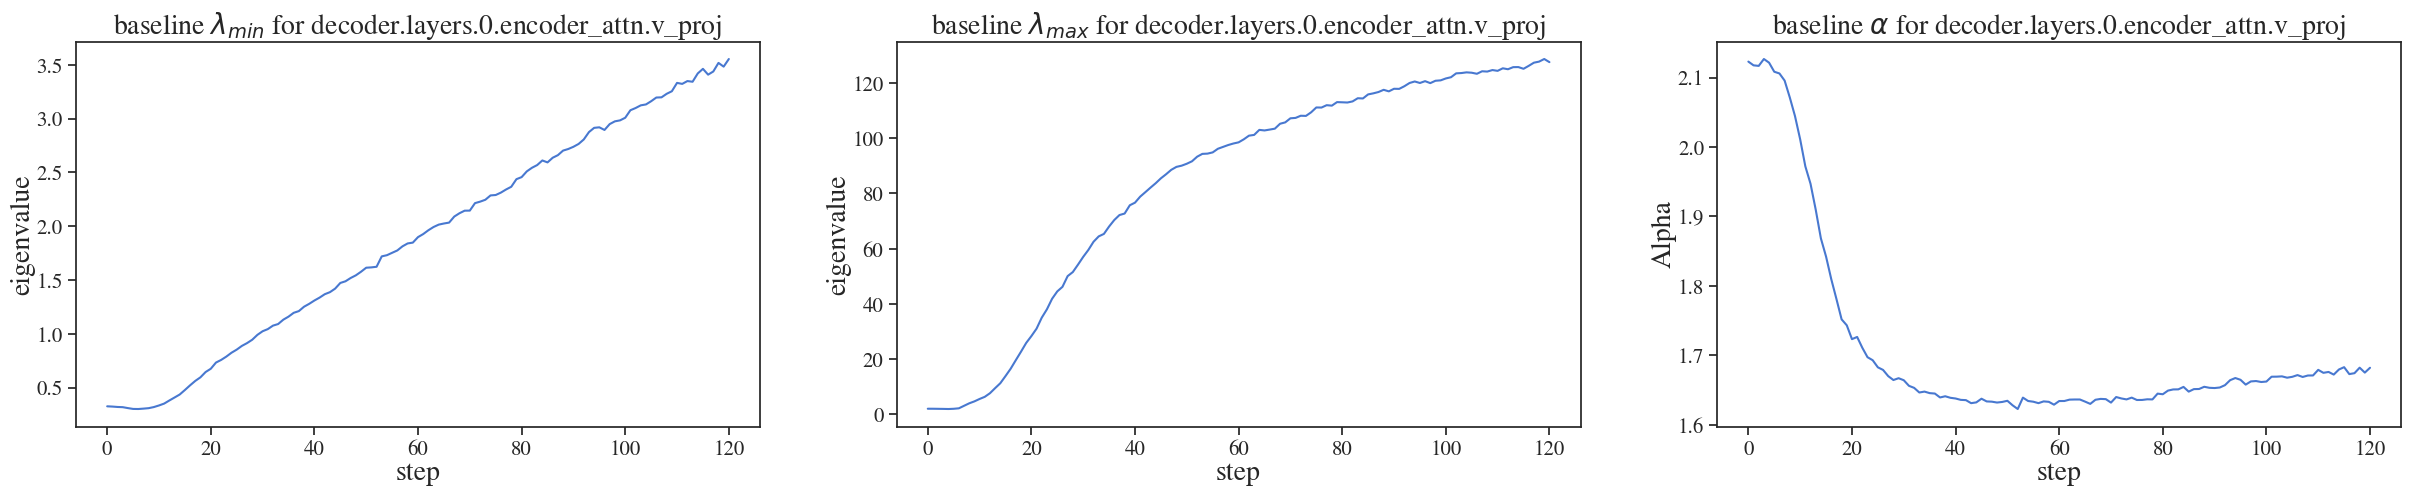

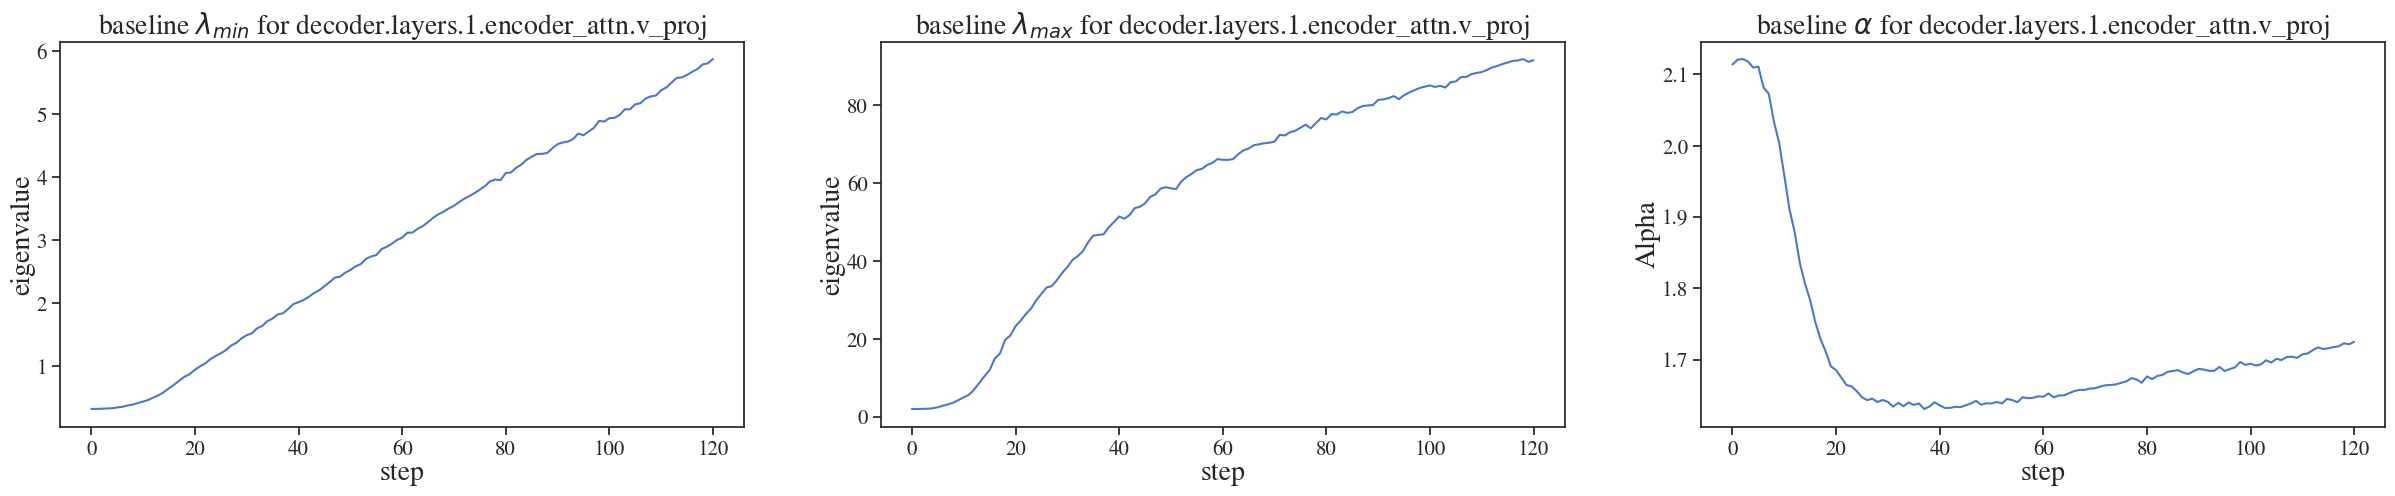

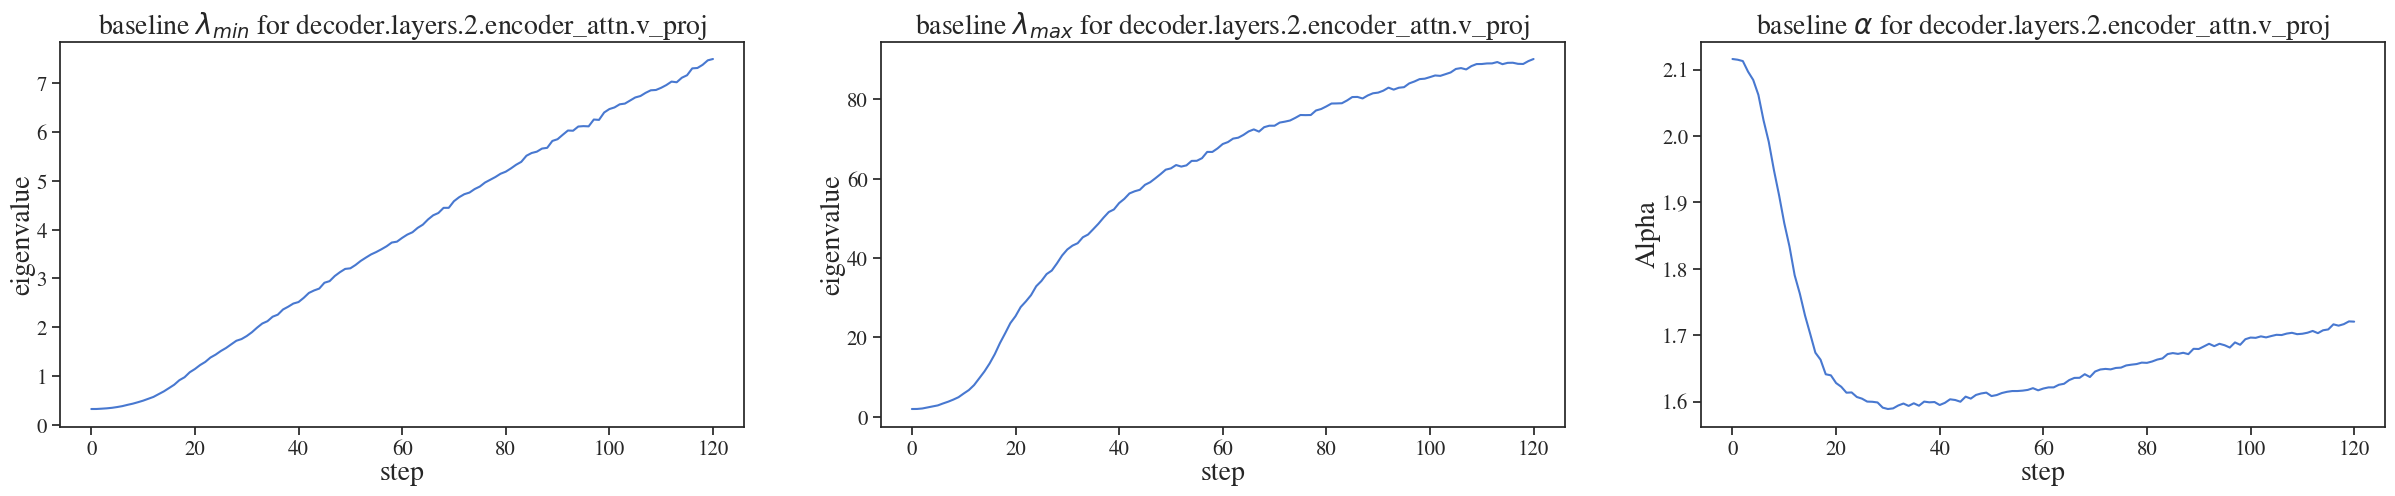

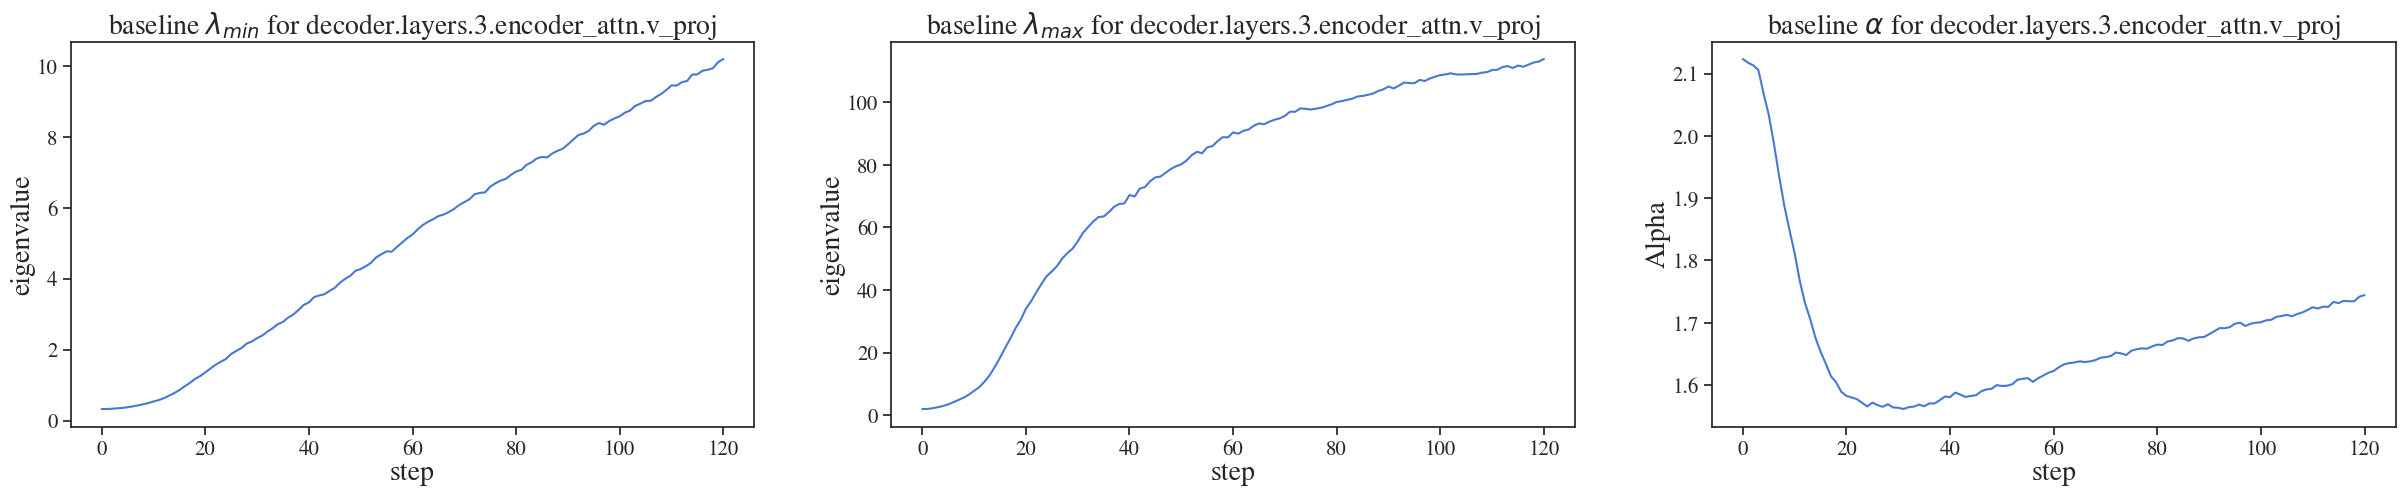

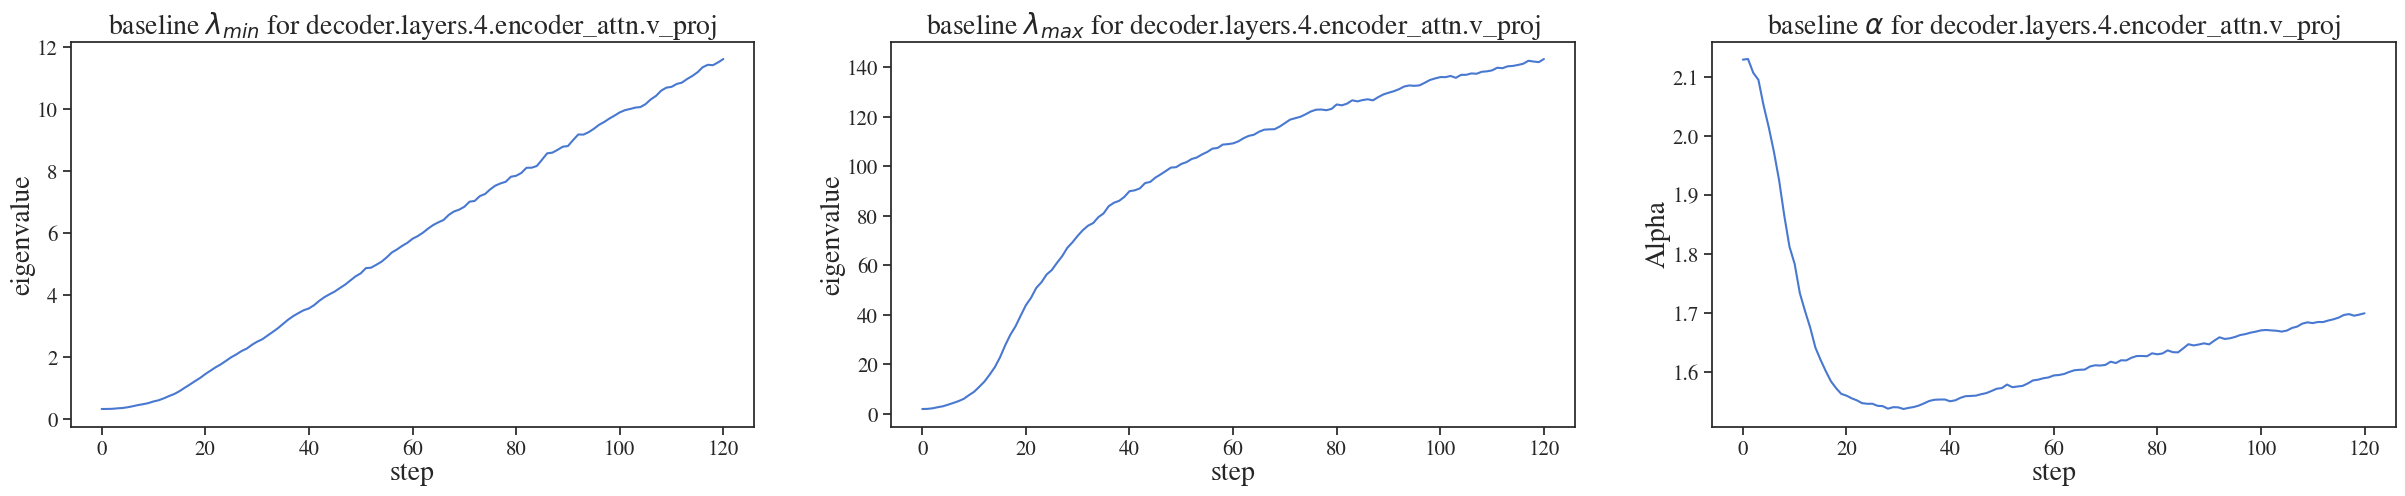

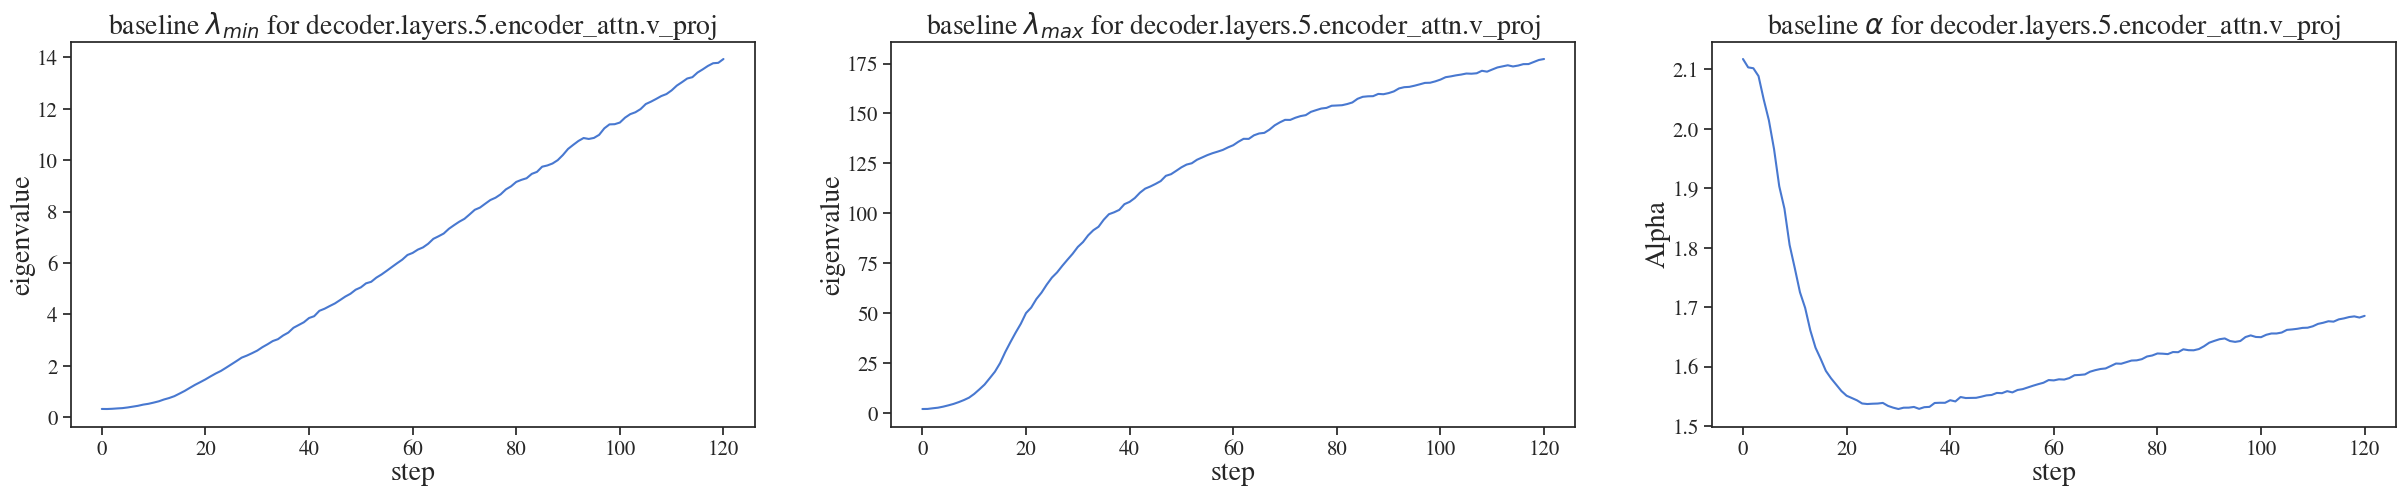

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import io
from contextlib import redirect_stdout, redirect_stderr
import powerlaw

from collections import defaultdict
import matplotlib as mpl
import numpy as np

params = {'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':12,
         'ytick.labelsize':15,
         'axes.titlepad': 1,
         'axes.labelpad': 1,
         'axes.grid': True,
          'legend.fontsize': 15
    }
mpl.rcParams.update(params)

import numpy as np
import matplotlib.pyplot as plt
import random
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
import matplotlib.cbook


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import json

# c = 'steelblue'
# base_c = 'lightskyblue'
import seaborn as sns
c = 'coral'
c1 = 'yellowgreen'
base_c = 'aqua'

plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='STIXGeneral')

yaxisfont=45
bigfont = 27 + 5
medfont = 15 
smallfont = 17

plt.rcParams['xtick.labelsize']=medfont
plt.rcParams['ytick.labelsize']=medfont
plt.rcParams['axes.titlesize']=medfont

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 16})

sns.set_palette("muted")
cmap = sns.color_palette("tab10")
ticks_fontsize = 18
label_fontsize = 20
cbar_fontsize = 18


EVALS_THRESH = 0.00001
thresh = EVALS_THRESH
XMIN_PEAK = 'xmin_peak'
XMIN_MID = 'xmin_mid'
POWER_LAW = 'power_law'
TRUNCATED_POWER_LAW='truncated_power_law'
xmin_pos = 2

def pl_fit(data=None, xmin=None, xmax=None, verbose=False, distribution='PL'):
    f = io.StringIO()
    with redirect_stdout(f), redirect_stderr(f), warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        return powerlaw.Fit(data, xmin=xmin, xmax=xmax, 
                verbose=verbose, distribution=distribution, 
                xmin_distribution=distribution)

def plot_loghist(x, bins, xmin, legend, color):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, density=True, alpha=0.2, label=legend, color=color)

    if xmin:
        plt.axvline(xmin, color=color, label=r'$\lambda_{min}$')

    plt.xscale('log')

ckpt_dict = {
    'baseline': 'baseline/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43',
    # 'cross_acc_v_0.2_1.6': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.2_slope1.6',
    # 'cross_acc_v_0.4_1.2': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.4_slope1.2',
    # 'cross_acc_v_0.5_1.0': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.5_slope1.0',
    # 'cross_acc_v_0.6_0.8': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.6_slope0.8',
    # 'cross_acc_v_0.8_0.4': 'adam_cross_acc_v/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.8_slope0.4',
}
task = 'mt_iwslt14_de_en'
ckpt_dir = '/scratch/tpang/zhliu/checkpoints/nlp/mt/iwslt14_de_en'

distribution = 'power_law' #truncated_ truncated_
fit_type=distribution
fix_fingers="xmin_mid" #"xmin_peak"
c_idx = 0
layer_name = 'decoder.layers.5.encoder_attn.v_proj'
plot_names = [
    'decoder.layers.0.encoder_attn.v_proj',
    'decoder.layers.1.encoder_attn.v_proj',
    'decoder.layers.2.encoder_attn.v_proj',
    'decoder.layers.3.encoder_attn.v_proj',
    'decoder.layers.4.encoder_attn.v_proj',
    'decoder.layers.5.encoder_attn.v_proj',
]

for config in ckpt_dict.keys():
    for layer_name in plot_names:
        seed_dir = os.path.join(ckpt_dir, ckpt_dict[config])
        xmin_list = []
        alpha_list = []
        xmax_list = []
        for step in range(0, 60500, 500):
            esd = np.load(os.path.join(seed_dir, f'metrics_update{step}.npy'), allow_pickle=True).item()
            layer_names = esd['longname']
            layer_idx = esd['longname'].index(layer_name)
            evals = esd['eigs'][layer_idx]
            plt.figure(figsize=(10, 8))
            title = f'{layer_name}, fit: {fix_fingers} \n'
            xmax = np.max(evals)
            xmax_list.append(xmax)

            if fix_fingers==XMIN_PEAK:
                print("fix the fingers by setting xmin to the peak of the ESD")
                # nz_evals = evals[evals > thresh]
                nz_evals = evals
                num_bins = 100  # np.min([100, len(nz_evals)])
                h = np.histogram(np.log10(nz_evals), bins=num_bins)
                ih = np.argmax(h[0])
                xmin2 = 10 ** h[1][ih]
                xmin_range = (0.95 * xmin2, 1.05 * xmin2)
                fit = pl_fit(data=nz_evals, xmin=xmin_range,
                    xmax=xmax, verbose=False, 
                    distribution=distribution)

            elif fix_fingers==XMIN_MID:
                # print("fix the fingers by setting xmin to the mid of the ESD")
                # nz_evals = evals[evals > thresh]
                nz_evals = evals
                i = int(len(nz_evals) / xmin_pos)
                xmin = nz_evals[i]
                fit = pl_fit(data=nz_evals, xmin=xmin,
                    xmax=xmax, verbose=False, 
                    distribution=distribution)

            else: 
                print("powerlaw.Fit no xmin , distribution={} ".format(distribution))
                # nz_evals = evals[evals > thresh]
                nz_evals = evals
                fit = pl_fit(data=nz_evals, xmax=xmax, verbose=False, distribution=distribution) 
            
            xmin = fit.xmin
            alpha = fit.alpha
            D = fit.D
            if fit_type==TRUNCATED_POWER_LAW:
                alpha = fit.truncated_power_law.alpha
                Lambda = fit.truncated_power_law.Lambda
                D = fit.truncated_power_law.D

            xmin_list.append(xmin)
            alpha_list.append(alpha)
            fig2 = fit.plot_pdf(color='b', linewidth=0) # invisbile
            fig2 = fit.plot_pdf(color=cmap[c_idx], linewidth=2) #color='orange',
            if fit_type==POWER_LAW:
                fit.power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2) #color='r',
                title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                    r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                    r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + \
                    f'num of eigs: {len(nz_evals)}' "\n" 
            else:
                fit.truncated_power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2)
                title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                    r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                    r'$Lambda=$'+"{0:.3f};".format(Lambda) + \
                    r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + "\n"

            plot_loghist(evals[evals>(xmin/100)], 
                        bins=100, xmin=xmin, legend=f'Epoch=best', color=cmap[c_idx])
            
            plt.title(title)
            plt.legend()
            plt.tight_layout()

            # make new dir if not exist
            if not os.path.exists(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch/{layer_name}"):
                os.makedirs(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch/{layer_name}")

            plt.savefig(f"/scratch/tpang/zhliu/figures/esd/{task}/{config}/fix_{fix_fingers}/transformer_lm/best_epoch/{layer_name}/esd_step{step}.png")
            plt.close()

        # plot xmin and alpha:
        fig, axs = plt.subplots(1, 3, figsize=(30, 5))
        axs[0].plot(xmin_list)
        axs[1].plot(xmax_list)
        axs[2].plot(alpha_list)

        axs[0].set_xlabel('step', fontsize=20)
        axs[0].set_ylabel('eigenvalue', fontsize=20)
        axs[0].set_title(f"{config} " + r"$\lambda_{min}$" + f" for {layer_name}", fontsize=20)
        # axs[0].legend()

        axs[1].set_xlabel('step', fontsize=20)
        axs[1].set_ylabel('eigenvalue', fontsize=20)
        axs[1].set_title(f"{config} " + r"$\lambda_{max}$" + f" for {layer_name}", fontsize=20)
        # axs[0].legend()

        axs[2].set_xlabel('step', fontsize=20)
        axs[2].set_ylabel('Alpha', fontsize=20)
        axs[2].set_title(f"{config} " + r"$\alpha$" f' for {layer_name}', fontsize=20)
        # axs[2].legend()
        plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import io
from contextlib import redirect_stdout, redirect_stderr
import powerlaw

from collections import defaultdict
import matplotlib as mpl
import numpy as np

params = {'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':12,
         'ytick.labelsize':15,
         'axes.titlepad': 1,
         'axes.labelpad': 1,
         'axes.grid': True,
          'legend.fontsize': 15
    }
mpl.rcParams.update(params)

import numpy as np
import matplotlib.pyplot as plt
import random
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
import matplotlib.cbook


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import json

# c = 'steelblue'
# base_c = 'lightskyblue'
import seaborn as sns
c = 'coral'
c1 = 'yellowgreen'
base_c = 'aqua'

plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='STIXGeneral')

yaxisfont=45
bigfont = 27 + 5
medfont = 15 
smallfont = 17

plt.rcParams['xtick.labelsize']=medfont
plt.rcParams['ytick.labelsize']=medfont
plt.rcParams['axes.titlesize']=medfont

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 16})

sns.set_palette("muted")
cmap = sns.color_palette("tab10")
ticks_fontsize = 18
label_fontsize = 20
cbar_fontsize = 18


EVALS_THRESH = 0.00001
thresh = EVALS_THRESH
XMIN_PEAK = 'xmin_peak'
XMIN_MID = 'xmin_mid'
POWER_LAW = 'power_law'
TRUNCATED_POWER_LAW='truncated_power_law'
xmin_pos = 2

def pl_fit(data=None, xmin=None, xmax=None, verbose=False, distribution='PL'):
    f = io.StringIO()
    with redirect_stdout(f), redirect_stderr(f), warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        return powerlaw.Fit(data, xmin=xmin, xmax=xmax, 
                verbose=verbose, distribution=distribution, 
                xmin_distribution=distribution)

def plot_loghist(x, bins, xmin, legend, color):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, density=True, alpha=0.2, label=legend, color=color)

    if xmin:
        plt.axvline(xmin, color=color, label=r'$\lambda_{min}$')

    plt.xscale('log')

task = 'mt_iwslt14_de_en'
model = 'transformer_lm'
config_dict = {
    'baseline': '/data/yefan0726/checkpoints/zihang/nlp/mt/iwslt14_de_en/baseline/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/',
    'acc_mid_0.5_1.0': '/data/yefan0726/checkpoints/zihang/nlp/mt/iwslt14_de_en/adam_acc_mid/transformer_iwslt_de_en_v2_iwslt14_de_en_seed43/min_0.5_slope1.0',
}
config = 'acc_mid_0.5_1.0'
ckpt_dir = config_dict[config]

distribution = 'power_law' #truncated_ truncated_
fit_type=distribution
fix_fingers="xmin_mid" #"xmin_peak"
c_idx = 0
lr_list = [0.005, 0.01, 0.02, 0.025, 0.05, 0.1]
lr = 0.000125
warmup = 0

# seed_dir = os.path.join(ckpt_dir, f'seed_13_lr_0.000125')
seed_dir = ckpt_dir
config = 'baseline'

first_esd = np.load(os.path.join(seed_dir, 'metrics_update0.npy'), allow_pickle=True).item()
for idx, layer_name in enumerate(first_esd['longname']):
    xmin_list = []
    alpha_list = []
    xmax_list = []
    for step in range(0, 60500, 500):
        esd = np.load(os.path.join(seed_dir, f'metrics_update{step}.npy'), allow_pickle=True).item()
        evals = esd['eigs'][idx]
        plt.figure(figsize=(10, 8))
        title = f'{layer_name}, fit: {fix_fingers} \n'
        xmax = np.max(evals)
        xmax_list.append(xmax)

        if fix_fingers==XMIN_PEAK:
            print("fix the fingers by setting xmin to the peak of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            num_bins = 100  # np.min([100, len(nz_evals)])
            h = np.histogram(np.log10(nz_evals), bins=num_bins)
            ih = np.argmax(h[0])
            xmin2 = 10 ** h[1][ih]
            xmin_range = (0.95 * xmin2, 1.05 * xmin2)
            fit = pl_fit(data=nz_evals, xmin=xmin_range,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        elif fix_fingers==XMIN_MID:
            # print("fix the fingers by setting xmin to the mid of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            i = int(len(nz_evals) / xmin_pos)
            xmin = nz_evals[i]
            fit = pl_fit(data=nz_evals, xmin=xmin,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        else: 
            print("powerlaw.Fit no xmin , distribution={} ".format(distribution))
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            fit = pl_fit(data=nz_evals, xmax=xmax, verbose=False, distribution=distribution) 
        
        xmin = fit.xmin
        alpha = fit.alpha
        D = fit.D
        if fit_type==TRUNCATED_POWER_LAW:
            alpha = fit.truncated_power_law.alpha
            Lambda = fit.truncated_power_law.Lambda
            D = fit.truncated_power_law.D

        xmin_list.append(xmin)
        alpha_list.append(alpha)
        fig2 = fit.plot_pdf(color='b', linewidth=0) # invisbile
        fig2 = fit.plot_pdf(color=cmap[c_idx], linewidth=2) #color='orange',
        if fit_type==POWER_LAW:
            fit.power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2) #color='r',
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + \
                f'num of eigs: {len(nz_evals)}' "\n" 
        else:
            fit.truncated_power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2)
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r'$Lambda=$'+"{0:.3f};".format(Lambda) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + "\n"

        plot_loghist(evals[evals>(xmin/100)], 
                    bins=100, xmin=xmin, legend=f'Epoch=best', color=cmap[c_idx])
        
        plt.title(title)
        plt.legend()
        plt.tight_layout()

        # make new dir if not exist
        if not os.path.exists(f"/data/yefan0726/checkpoints/zihang/figures/esd/{task}/{model}/{config}/fix_{fix_fingers}/layer_{layer_name}"):
            os.makedirs(f"/data/yefan0726/checkpoints/zihang/figures/esd/{task}/{model}/{config}/fix_{fix_fingers}/layer_{layer_name}")

        plt.savefig(f"/data/yefan0726/checkpoints/zihang/figures/esd/{task}/{model}/{config}/fix_{fix_fingers}/layer_{layer_name}/esd_step_{step}.png")
        plt.close()


    # plot xmin and alpha:
    fig, axs = plt.subplots(1, 3, figsize=(30, 5))
    axs[0].plot(xmin_list)
    axs[1].plot(xmax_list)
    axs[2].plot(alpha_list)

    axs[0].set_xlabel('step', fontsize=20)
    axs[0].set_ylabel('eigenvalue', fontsize=20)
    axs[0].set_title(r"$\lambda_{min}$" + f" for {layer_name}", fontsize=20)
    # axs[0].legend()

    axs[1].set_xlabel('step', fontsize=20)
    axs[1].set_ylabel('eigenvalue', fontsize=20)
    axs[1].set_title(r"$\lambda_{max}$" + f" for {layer_name}", fontsize=20)
    # axs[0].legend()

    axs[2].set_xlabel('step', fontsize=20)
    axs[2].set_ylabel('Alpha', fontsize=20)
    axs[2].set_title(r"$\alpha$" f' for {layer_name}', fontsize=20)

    plt.savefig(f"/data/yefan0726/checkpoints/zihang/figures/esd/{task}/{model}/{config}/fix_{fix_fingers}/layer_{layer_name}/metrics.png")
    plt.close()

/data/yefan0726/anaconda3/envs/ww_prune/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import io
from contextlib import redirect_stdout, redirect_stderr
import powerlaw

from collections import defaultdict
import matplotlib as mpl
import numpy as np

params = {'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':12,
         'ytick.labelsize':15,
         'axes.titlepad': 1,
         'axes.labelpad': 1,
         'axes.grid': True,
          'legend.fontsize': 15
    }
mpl.rcParams.update(params)

import numpy as np
import matplotlib.pyplot as plt
import random
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
import matplotlib.cbook


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import json

# c = 'steelblue'
# base_c = 'lightskyblue'
import seaborn as sns
c = 'coral'
c1 = 'yellowgreen'
base_c = 'aqua'

plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='STIXGeneral')

yaxisfont=45
bigfont = 27 + 5
medfont = 15 
smallfont = 17

plt.rcParams['xtick.labelsize']=medfont
plt.rcParams['ytick.labelsize']=medfont
plt.rcParams['axes.titlesize']=medfont

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 16})

sns.set_palette("muted")
cmap = sns.color_palette("tab10")
ticks_fontsize = 18
label_fontsize = 20
cbar_fontsize = 18


EVALS_THRESH = 0.00001
thresh = EVALS_THRESH
XMIN_PEAK = 'xmin_peak'
XMIN_MID = 'xmin_mid'
POWER_LAW = 'power_law'
TRUNCATED_POWER_LAW='truncated_power_law'
xmin_pos = 2

def pl_fit(data=None, xmin=None, xmax=None, verbose=False, distribution='PL'):
    f = io.StringIO()
    with redirect_stdout(f), redirect_stderr(f), warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        return powerlaw.Fit(data, xmin=xmin, xmax=xmax, 
                verbose=verbose, distribution=distribution, 
                xmin_distribution=distribution)

def plot_loghist(x, bins, xmin, legend, color):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, density=True, alpha=0.2, label=legend, color=color)

    if xmin:
        plt.axvline(xmin, color=color, label=r'$\lambda_{min}$')

    plt.xscale('log')

task = 'lm_ptb'
model = 'tensorized_transformer'
# ckpt_dir = '/scratch/tpang/zhliu/checkpoints/nlp/lm/tensorized/baseline/ptb-adam/bs120/tensor_transformer_3layer/head_1/max_step40000_max_epoch200_log_interval200/xmin_mid_xmin_pos2/warmup_0'
config_dict = {
    'baseline': '/scratch/tpang/zhliu/checkpoints/nlp/lm/tensorized/baseline/ptb-adam/bs120/tensor_transformer_3layer/head_1/max_step40000_max_epoch200_log_interval200/xmin_mid_xmin_pos2/warmup_0',
    'acc_mid': '/data/yefan0726/checkpoints/zihang/nlp/lm/tensorized/tb_stage_update/ptb-adam/bs120-remove_last-eigs_thresh_50/tensor_transformer_3layer/head_1/max_step40000_max_epoch200_log_interval200_esd_interval1/tune_middleTrue_lr_scale_1.5/alpha_xmin_mid_min1.0_slope1.0_xmin_pos2.0_late_start_False/warmup_0_usetb_before_True'
}
distribution = 'power_law' #truncated_ truncated_
fit_type=distribution
fix_fingers="xmin_mid" #"xmin_peak"
c_idx = 0
lr_list = [0.005, 0.01, 0.02, 0.025, 0.05, 0.1]
lr = 0.000125
warmup = 0

config = 'acc_mid'
ckpt_dir = config_dict[config]

seed_dir = os.path.join(ckpt_dir, f'seed_13_lr_{lr}')
first_esd = np.load(os.path.join(seed_dir, 'stats/esd_epoch_0.npy'), allow_pickle=True).item()
for idx, layer_name in enumerate(first_esd['longname']):
    xmin_list = []
    alpha_list = []
    xmax_list = []
    for epoch in range(0, 167):
        esd = np.load(os.path.join(seed_dir, f'stats/esd_epoch_{epoch}.npy'), allow_pickle=True).item()
        evals = esd['eigs'][idx]
        plt.figure(figsize=(10, 8))
        title = f'{layer_name}, fit: {fix_fingers} \n'
        xmax = np.max(evals)
        xmax_list.append(xmax)

        if fix_fingers==XMIN_PEAK:
            print("fix the fingers by setting xmin to the peak of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            num_bins = 100  # np.min([100, len(nz_evals)])
            h = np.histogram(np.log10(nz_evals), bins=num_bins)
            ih = np.argmax(h[0])
            xmin2 = 10 ** h[1][ih]
            xmin_range = (0.95 * xmin2, 1.05 * xmin2)
            fit = pl_fit(data=nz_evals, xmin=xmin_range,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        elif fix_fingers==XMIN_MID:
            # print("fix the fingers by setting xmin to the mid of the ESD")
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            i = int(len(nz_evals) / xmin_pos)
            xmin = nz_evals[i]
            fit = pl_fit(data=nz_evals, xmin=xmin,
                xmax=xmax, verbose=False, 
                distribution=distribution)

        else: 
            print("powerlaw.Fit no xmin , distribution={} ".format(distribution))
            # nz_evals = evals[evals > thresh]
            nz_evals = evals
            fit = pl_fit(data=nz_evals, xmax=xmax, verbose=False, distribution=distribution) 
        
        xmin = fit.xmin
        alpha = fit.alpha
        D = fit.D
        if fit_type==TRUNCATED_POWER_LAW:
            alpha = fit.truncated_power_law.alpha
            Lambda = fit.truncated_power_law.Lambda
            D = fit.truncated_power_law.D

        xmin_list.append(xmin)
        alpha_list.append(alpha)
        fig2 = fit.plot_pdf(color='b', linewidth=0) # invisbile
        fig2 = fit.plot_pdf(color=cmap[c_idx], linewidth=2) #color='orange',
        if fit_type==POWER_LAW:
            fit.power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2) #color='r',
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + \
                f'num of eigs: {len(nz_evals)}' "\n" 
        else:
            fit.truncated_power_law.plot_pdf(color=cmap[c_idx], linestyle='--', ax=fig2)
            title = title + rf"Epoch: best $\alpha=${alpha:.3f}; " + \
                r'$D_{KS}=$'+"{0:.3f}; ".format(D) + \
                r'$Lambda=$'+"{0:.3f};".format(Lambda) + \
                r"$\lambda_{min}=$"+"{0:.3f}".format(xmin) + "\n"

        plot_loghist(evals[evals>(xmin/100)], 
                    bins=100, xmin=xmin, legend=f'Epoch=best', color=cmap[c_idx])
        
        plt.title(title)
        plt.legend()
        plt.tight_layout()

        # make new dir if not exist
        if not os.path.exists(f"/data/yefan0726/checkpoints/zihang/figures/esd/{task}/{model}/{config}/fix_{fix_fingers}/lr_{lr}_warmup_{warmup}/layer_{layer_name}"):
            os.makedirs(f"/data/yefan0726/checkpoints/zihang/figures/esd/{task}/{model}/{config}/fix_{fix_fingers}/lr_{lr}_warmup_{warmup}/layer_{layer_name}")

        plt.savefig(f"/data/yefan0726/checkpoints/zihang/figures/esd/{task}/{model}/{config}/fix_{fix_fingers}/lr_{lr}_warmup_{warmup}/layer_{layer_name}/esd_epoch_{epoch}.png")
        plt.close()
        
    if not os.path.exists(f"/data/yefan0726/checkpoints/zihang/figures/training_dynamic/{task}/{model}/{config}/fix_{fix_fingers}/lr_{lr}_warmup_{warmup}/layer_{layer_name}"): 
        os.makedirs(f"/data/yefan0726/checkpoints/zihang/figures/training_dynamic/{task}/{model}/{config}/fix_{fix_fingers}/lr_{lr}_warmup_{warmup}/layer_{layer_name}")                      
    # plot xmin and alpha:
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(xmin_list)
    axs[1].plot(xmax_list)
    axs[0].set_xlabel('epoch', fontsize=20)
    axs[0].set_ylabel('eigenvalue', fontsize=20)
    axs[0].set_title(r"$\lambda_{min}$" + f" for layer: {layer_name}, lr = {lr}", fontsize=20)
    # axs[0].legend()

    axs[1].set_xlabel('epoch', fontsize=20)
    axs[1].set_ylabel('eigenvalue', fontsize=20)
    axs[1].set_title(r"$\lambda_{max}$" + f" for layer: {layer_name}, lr = {lr}", fontsize=20)
    # axs[1].legend()
    plt.savefig(f"/data/yefan0726/checkpoints/zihang/figures/training_dynamic/{task}/{model}/{config}/fix_{fix_fingers}/lr_{lr}_warmup_{warmup}/layer_{layer_name}/lambda_mid_max.png")
    plt.close()

    # get the loss
    stats = np.load(os.path.join(seed_dir, 'training_stats.npy'), allow_pickle=True).item()

    # plot xmin and alpha:
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(alpha_list)
    axs[1].plot(stats['test_loss'])
    axs[0].set_xlabel('epoch', fontsize=20)
    axs[0].set_ylabel('alpha', fontsize=20)
    axs[0].set_title(r"$\alpha$" + f" for layer: {layer_name}, lr = {lr}", fontsize=20)
    # axs[0].legend()

    axs[1].set_xlabel('epoch', fontsize=20)
    axs[1].set_ylabel('eigenvalue', fontsize=20)
    axs[1].set_title(f"Loss for layer: {layer_name}, lr = {lr}", fontsize=20)
    # axs[1].legend()
    plt.savefig(f"/data/yefan0726/checkpoints/zihang/figures/training_dynamic/{task}/{model}/{config}/fix_{fix_fingers}/lr_{lr}_warmup_{warmup}/layer_{layer_name}/alpha_loss.png")
    plt.close()

/data/yefan0726/anaconda3/envs/ww_prune/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import numpy as np
l = np.array([0, 1, 2, 3, 4, 5])
l = abs(l - max(l) // 2)
l = len(l) / 2 - l
l

array([1., 2., 3., 2., 1., 0.])